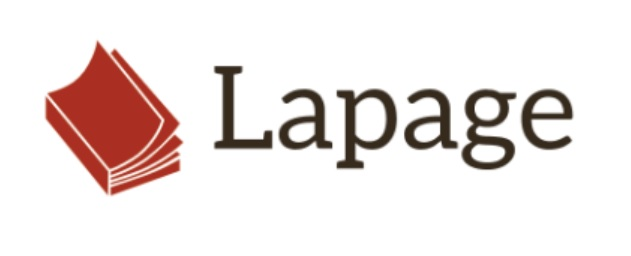


<font size="5">The scenario presented here is that you've recently been hired as a Data Analyst for an online book store.</font>

You are asked to respond to a list of queries by Antoine and Julie from the marketing department.

There are 3 csv files provided, namely:

1. Customers 
2. Products
3. Transactions 

Antoine needs information on the sales figures and customer profiles, namely:
1. The evolution of the sales figures since the launch of the website.
2. The sales figures per age and per session.
3. A list of best and worst selling books and categories.
4. The customer profiles by
    1. age,
    2. gender,
    3. the proportion of amount spent using a Lorenz curve and gini coefficient.

Julie needs information on:

5. The relationship between the gender of the customer and the category of book bought.
6. The correlation between the age of the customer and 
    1. the amount spent,
    2. the frequency of purchase,
    3. the average of shopping basket amount,
    4. the book categories.
7. The probability of a client buying product 0_525 if they've bought product 2_159.

# Step 1: Importing libraries

In [1]:
#Step 1: IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import datetime as dt
sns.set()

import warnings
warnings.filterwarnings("ignore")

# Step 2: IMPORTING & ANALYSING DATA
## 1. The customers file with:
    1. Client_id
    2. The sex (gender) of the client
    3. Year of birth

In [2]:
customers = pd.read_csv(r"C:\Users\caspe\OneDrive\Documenten\Casper\OpenClassroom\Project 6\customers.csv")
customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [3]:
customers.dtypes

client_id    object
sex          object
birth         int64
dtype: object

Normally I would change the birth year to a datetime type but since we need to work with it to calculate the customers' ages
I have left it as it is.

In [4]:
#Format birth to datetime
#customers['birth'] = pd.to_datetime(customers['birth'], format= '%Y')

In [5]:
customers.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


### Having a look at the distribution of our customers by gender and age/age group

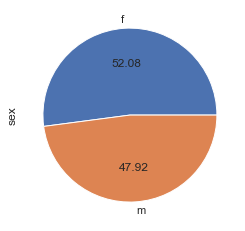

In [6]:
customers.sex.value_counts().plot(kind='pie', autopct='%.2f')
plt.show()

In [7]:
customers["age"] = dt.date.today().year - customers["birth"]
customers["age_group"] = pd.cut(customers["age"], bins=[15,25,35,45,55,65,75,100],\
                                labels = ["16-25","26-35","36-45","46-55","56-65","66-75","76-100"])
customers.head()

,client_id,sex,birth,age,age_group
0,c_4410,f,1967,55,46-55
1,c_7839,f,1975,47,46-55
2,c_1699,f,1984,38,36-45
3,c_5961,f,1962,60,56-65
4,c_5320,m,1943,79,76-100


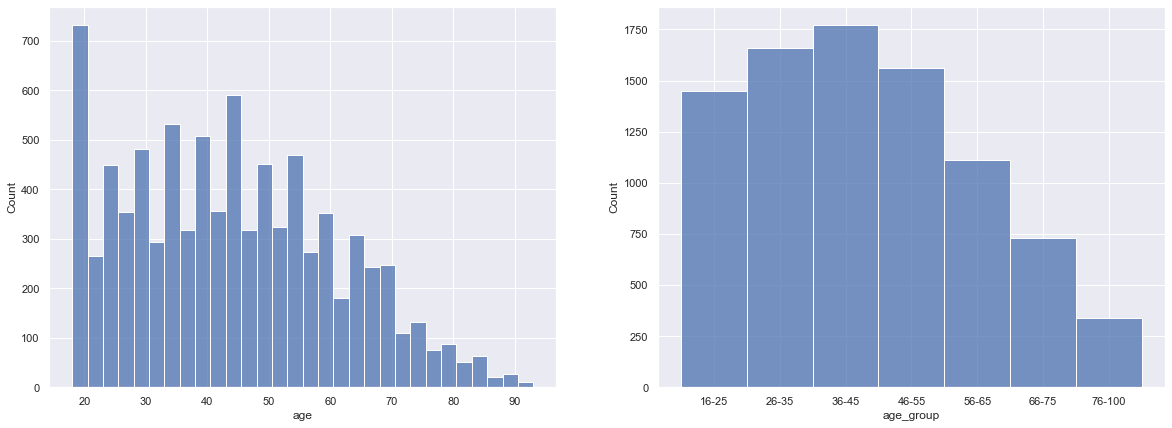

Minimum age: 18 and maximum age: 93


In [8]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
sns.histplot(customers["age"])

plt.subplot(1,2,2)
sns.histplot(customers["age_group"])
plt.show()
print("Minimum age:",customers["age"].min(), "and maximum age:", customers["age"].max())

## 2. The products file with:
    1. Product ID
    2. Price
    3. Category

In [9]:
products = pd.read_csv(r"C:\Users\caspe\OneDrive\Documenten\Casper\OpenClassroom\Project 6\products.csv")
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [10]:
products.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [11]:
products.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


In [12]:
# Having a look at the product(s) with a negative price
products[products["price"]<0]

,id_prod,price,categ
731,T_0,-1.0,0


<span style='background :black'><font color='white'>The product ID indicates this is a test product</font></span>

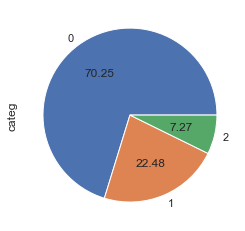

In [13]:
# Taking a look at the category distribution
products.categ.value_counts().plot(kind='pie', autopct='%.2f')
plt.show()

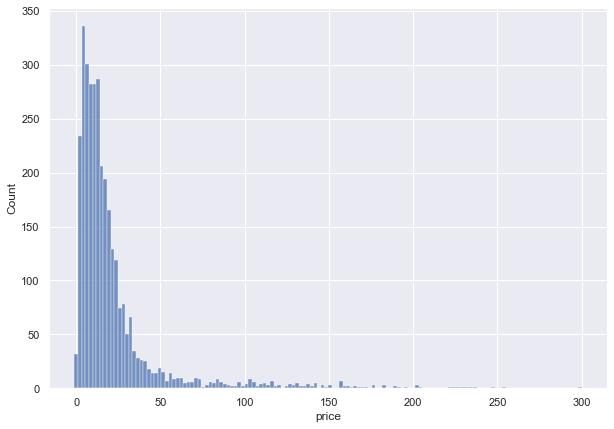

In [14]:
# Taking a look at the range of prices
plt.figure(figsize=(10,7))
sns.histplot(data =products, x="price" )
plt.show()

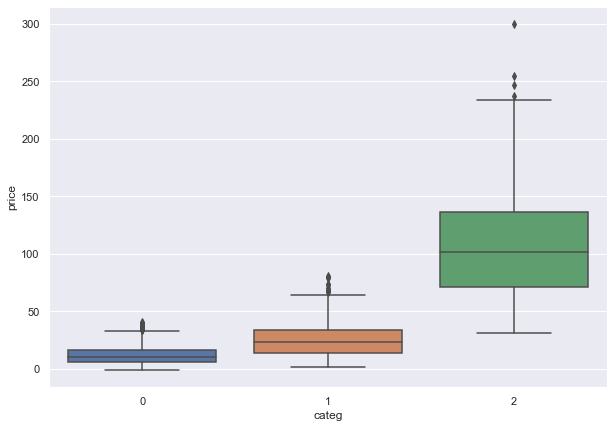

In [15]:
# Having a look at the price per category and identify any potential outliers
plt.figure(figsize=(10,7))
sns.boxplot(x = 'categ', y = 'price', data = products)
plt.show()

<font color='blue'>We can observe that the prices have very little overlap between the categories, but not none.
A potential explanation for this is that the categories are based on price but as more products were added this convention wasn't always adhered to.</font>

## 3. The transactions file with:
    1. Product ID
    2. The date and time of the transaction
    3. Session ID
    4. Client ID

In [16]:
transactions = pd.read_csv(r"C:\Users\caspe\OneDrive\Documenten\Casper\OpenClassroom\Project 6\transactions.csv")
transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [17]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

In [18]:
transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


In [19]:
transactions.loc[transactions['session_id'] == 's_0']

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


#### When taking a closer look at the sessions with id s_0 we find they're the test sessions and by removing them we'll also eliminate the test product id's and client id's

In [20]:
#drop test data
transactions.drop(transactions.loc[transactions['session_id'] == 's_0'].index, inplace=True)

In [21]:
#format date
transactions['date'] = pd.to_datetime(transactions['date'], format= '%Y-%m-%d %H:%M:%S')

In [22]:
transactions.shape

(679332, 4)

In [23]:
transactions.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

### Merging the files into a complete dataframe

In [24]:
full_data = transactions.merge(products, on='id_prod', how='left').merge(customers, on='client_id', how='left')
full_data.describe(include="all")

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,age_group
count,679332,679332,679332,679332,679111.000000,679111.000000,679332,679332.000000,679332.000000,679332
unique,3266,679332,342315,8600,NaN,NaN,2,NaN,NaN,7
top,1_369,2022-05-20 13:21:29.043970,s_118668,c_1609,NaN,NaN,m,NaN,NaN,36-45
freq,2252,1,14,25488,NaN,NaN,340930,NaN,NaN,235916
first,NaN,2021-03-01 00:01:07.843138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2023-02-28 23:58:30.792755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,17.454773,0.441953,NaN,1977.811139,44.188861,NaN
std,NaN,NaN,NaN,NaN,18.328998,0.595042,NaN,13.574553,13.574553,NaN
min,NaN,NaN,NaN,NaN,0.620000,0.000000,NaN,1929.000000,18.000000,NaN
25%,NaN,NaN,NaN,NaN,8.870000,0.000000,NaN,1970.000000,35.000000,NaN


In [25]:
#We're missing values for the price and categ features
missing_values = (full_data['price'].isnull()) | (full_data['categ'].isnull())
print("There are missing values for this product:", full_data[missing_values]["id_prod"].unique())

There are missing values for this product: ['0_2245']


In [26]:
#Correcting product 0_2245, by assigning it its correct category (0, as indicated by the product id)
#and then assigning it the mean price for that category:
full_data.loc[full_data.id_prod == "0_2245", "categ"] = 0
full_data['price'] = full_data['price'].fillna(full_data.groupby('categ')['price'].transform('mean'))
full_data.loc[full_data["id_prod"] == "0_2245"]

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,age_group
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,10.638188,0.0,m,1940,82,76-100
10103,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,10.638188,0.0,f,1963,59,56-65
11723,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,10.638188,0.0,m,1978,44,36-45
15670,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,10.638188,0.0,m,1991,31,26-35
16372,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,10.638188,0.0,m,1973,49,46-55
...,...,...,...,...,...,...,...,...,...,...
669533,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,10.638188,0.0,m,1981,41,36-45
670484,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,10.638188,0.0,f,1979,43,36-45
671088,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,10.638188,0.0,m,1981,41,36-45
675480,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,10.638188,0.0,m,1986,36,36-45


### Checking to see if any products have never been sold

In [27]:
#Unsold products:
trans_prod_nan = transactions.merge(products, on='id_prod', how='outer',indicator=True)
trans_prod_nan = trans_prod_nan[trans_prod_nan._merge == "right_only"]
trans_prod_nan

,id_prod,date,session_id,client_id,price,categ,_merge
679332,0_1016,NaT,NaN,NaN,35.06,0.0,right_only
679333,0_1780,NaT,NaN,NaN,1.67,0.0,right_only
679334,T_0,NaT,NaN,NaN,-1.00,0.0,right_only
679335,0_1062,NaT,NaN,NaN,20.08,0.0,right_only
679336,0_1119,NaT,NaN,NaN,2.99,0.0,right_only
679337,0_1014,NaT,NaN,NaN,1.15,0.0,right_only
679338,1_0,NaT,NaN,NaN,31.82,1.0,right_only
679339,0_1318,NaT,NaN,NaN,20.92,0.0,right_only
679340,0_1800,NaT,NaN,NaN,22.05,0.0,right_only
679341,0_1645,NaT,NaN,NaN,2.99,0.0,right_only


# Answering the questions:

### Question 1: The evolution of the sales figures since the launch of the website.

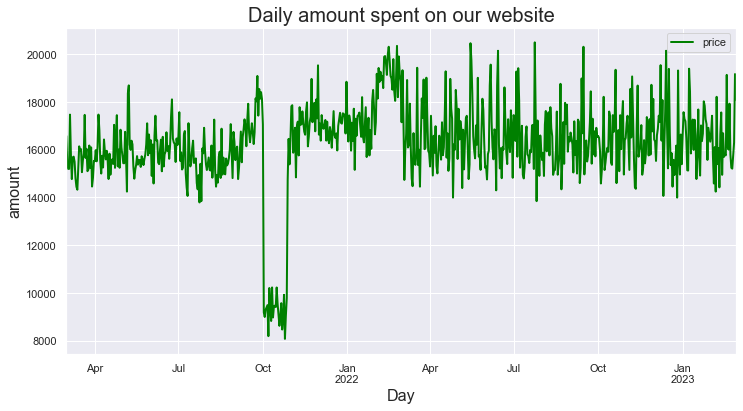

In [28]:
#Sales figures per day
trans_prod_day = full_data.groupby(pd.Grouper(key='date',freq='D')).agg({'price':'sum'})
trans_prod_day.plot(color='green', linewidth=2, figsize=(12,6))
plt.title('Daily amount spent on our website', fontsize=20)
plt.xlabel('Day', fontsize=16)
plt.ylabel('amount', fontsize=16)
plt.show()

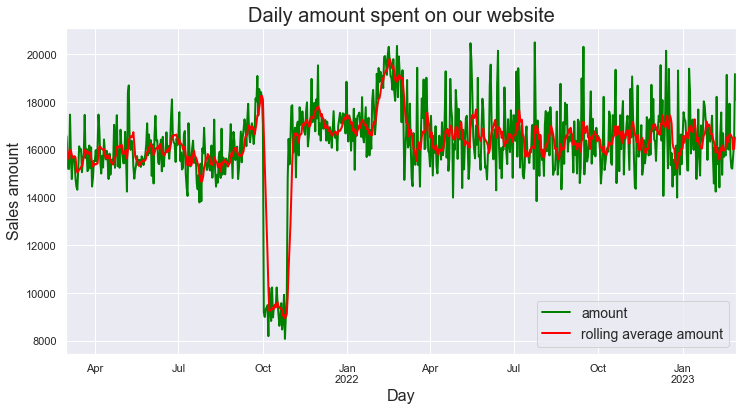

In [29]:
#Daily sales figures with a 7 day (weekly) rolling average
trans_prod_day['RollAvg'] = trans_prod_day.rolling(7, min_periods=1).mean()
colors = ['green', 'red']
trans_prod_day.plot(color=colors, linewidth=2, figsize=(12,6))
plt.legend(labels =['amount', 'rolling average amount'], fontsize=14)
plt.title('Daily amount spent on our website', fontsize=20)
plt.xlabel('Day', fontsize=16)
plt.ylabel('Sales amount', fontsize=16)
plt.show()

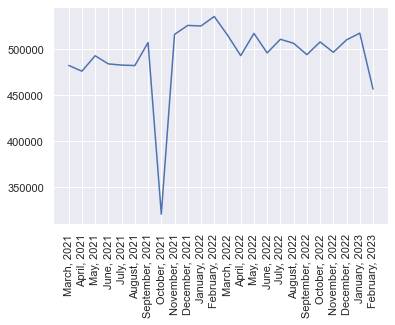

In [30]:
#Monthly sales evolution
trans_prod_month = full_data.groupby(pd.Grouper(key='date',freq='M')).agg({'price':'sum'})
trans_prod_month.index = trans_prod_month.index.strftime('%B, %Y')
plt.plot(trans_prod_month['price'])
plt.xticks(rotation = 'vertical')
plt.show()

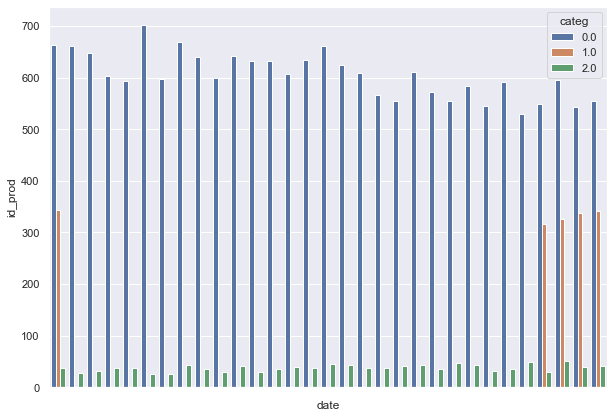

In [31]:
#why the dip in October 2021?
#checking categories in October
trans_oct = full_data[(full_data['date'] > "2021-10-01") & (full_data['date'] < "2021-11-01")]
trans_oct_categ = trans_oct.set_index('date').groupby([pd.Grouper(freq='D'), 'categ']).count()
trans_oct_categ.reset_index(inplace=True)
trans_oct_categ.index = pd.DatetimeIndex(trans_oct_categ.date)
trans_oct_categ.drop(columns=['session_id','client_id','price','date'])

plt.figure(figsize=(10,7))
sns.barplot(data=trans_oct_categ,x="date",y="id_prod",hue="categ").set(xticklabels=[])
plt.show()

<font color='blue'>As we can see, products from category 1 were not sold for much of the month of October 2021.
Why this is is not clear, it could be a glitch, it could be an error, we could have run out of stock (although this seems unlikely). Further investigation would be necessary to find the cause but fortunately the problem seems to have been resolved by the end of the month</font>

### Question 2a: Sales by category

In [32]:
ca_categ = full_data.groupby(['categ'])[['price']].sum().reset_index()
ca_categ.style.format("{:.1f}")

,categ,price
0,0.0,4422082.0
1,1.0,4653722.7
2,2.0,2780275.0


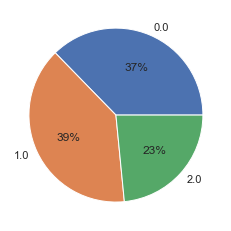

In [33]:
plt.pie(data=ca_categ, x="price",labels = 'categ', autopct='%.0f%%')
plt.show()

### Question 2b: Sales by gender

In [34]:
#in order to avoid the summed amounts to display in scientific notation I'm changing the display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)

ca_sexe = full_data.groupby(['sex'])[['price']].sum().reset_index()
ca_sexe

,sex,price
0,f,5860927.80
1,m,5995151.92


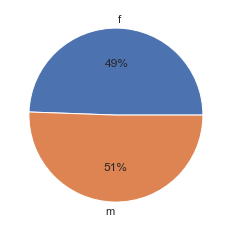

In [35]:
plt.pie(data=ca_sexe, x="price",labels = 'sex', autopct='%.0f%%')
plt.show()

### Question 2c: Sales by age group

In [60]:
#calculate Sales by age group
ca_age_group = full_data.groupby(['age_group'])[['price']].sum().reset_index()
ca_age_group

,age_group,price
0,16-25,2190905.79
1,26-35,2370752.43
2,36-45,3114034.38
3,46-55,2161898.36
4,56-65,1056079.28
5,66-75,666548.01
6,76-100,295861.48


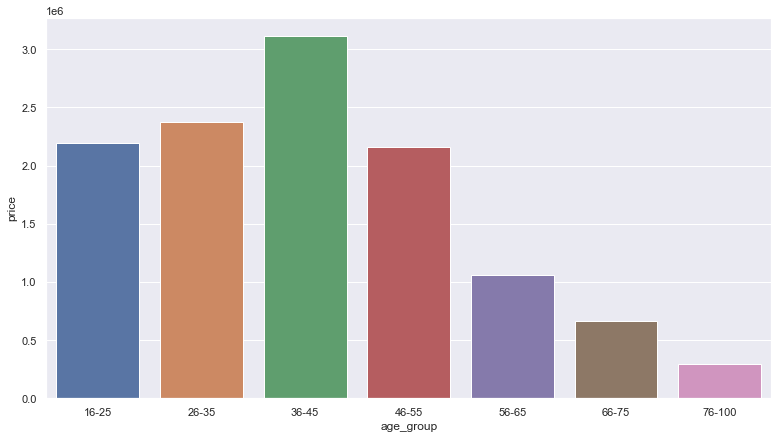

In [61]:
plt.figure(figsize=(13,7))
sns.barplot(data = ca_age_group, x = "age_group", y = "price")
plt.show()

### Question 2d: Average shopping basket per session

In [38]:
session_mean = full_data.groupby(['session_id'])[['price']].sum().mean()
print(session_mean)

price   34.63
dtype: float64


### Question 3a: Book sales tops & flops (by product)

In [39]:
#Top earners
full_data_prodprice = full_data.groupby('id_prod')['price'].sum().reset_index()
full_data_prodprice.sort_values('price', ascending=False).head(10)

,id_prod,price
3097,2_159,94893.50
3071,2_135,69334.95
3046,2_112,65407.76
3035,2_102,60736.78
3153,2_209,56971.86
2620,1_395,54356.25
2592,1_369,54025.48
3044,2_110,53846.25
3202,2_39,53060.85
3105,2_166,52449.12


In [40]:
#lowest earners
full_data_prodprice.sort_values('price').head(10)

,id_prod,price
595,0_1539,0.99
313,0_1284,1.38
719,0_1653,1.98
1785,0_541,1.99
2080,0_807,1.99
665,0_1601,1.99
802,0_1728,2.27
549,0_1498,2.48
2180,0_898,2.54
925,0_1840,2.56


### Question 3b: Book sales tops & flops (by category)

In [41]:
ca_cat_sorted = ca_categ.sort_values('price', ascending=False)
ca_cat_sorted.style.format("{:.1f}")

,categ,price
1,1.0,4653722.7
0,0.0,4422082.0
2,2.0,2780275.0


#### It needs to be born in mind that category 2 is the category with the most expensive books, which likely has a large influence on the amounts sold

### Question 4a: Client profile (age)

In [42]:
# Finding the age counts for each unique customer
cp_age = customers.groupby('age')['client_id'].count().reset_index()

# Finding the number of times someone of a certain age has bought one of our books
cp_age_full = full_data.groupby('age')['client_id'].count().reset_index()

#### When we compare the 2 graphs we can see that we have a large number of 18 year old customers but they don't spend much, especially compared to the 42 year olds

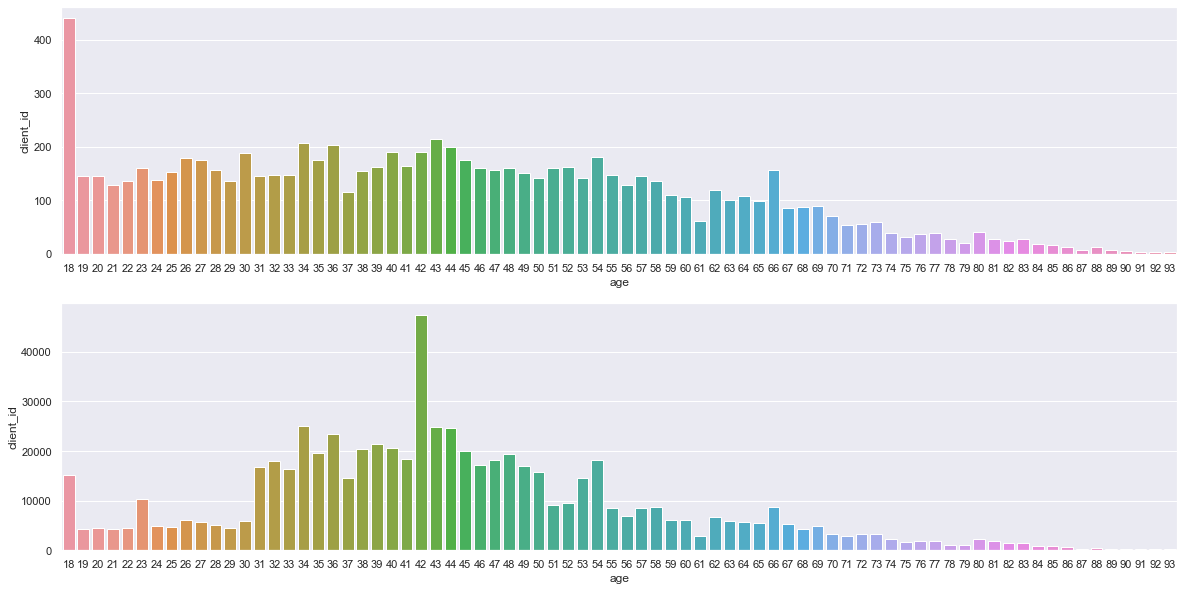

In [65]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.barplot(data=cp_age, x = 'age', y = 'client_id')
plt.subplot(2,1,2)
sns.barplot(data=cp_age_full, x = 'age', y = 'client_id')
plt.show()

### Question 4b: Client profile (gender)

In [44]:
cp_sexe = full_data.groupby('sex')['client_id'].count()
cp_sexe

sex
f    338402
m    340930
Name: client_id, dtype: int64

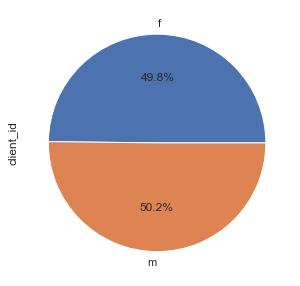

In [45]:
plot = cp_sexe.plot.pie(figsize=(5, 5), autopct='%1.1f%%')

#### These figures show how often a gender appears in our full dataframe and thus reflects the number of times someone of that gender has purchased something on our site.

### Question 4c: The customer profiles by the proportion of amount spent using a Lorenz curve and gini coefficient.

In [46]:
# Finding the amount each customer has spent
ca_customer = full_data.groupby('client_id')['price'].sum().reset_index()

# Sorting the result to be able to use it for a Lorenz curve
ca_cust_sorted = ca_customer.sort_values('price')
ca_cust_sorted

,client_id,price
8151,c_8351,6.31
7918,c_8140,8.30
7889,c_8114,9.98
1556,c_240,11.06
4044,c_4648,11.20
...,...,...
2513,c_3263,5276.87
2724,c_3454,113669.84
6337,c_6714,153662.75
4388,c_4958,289760.34


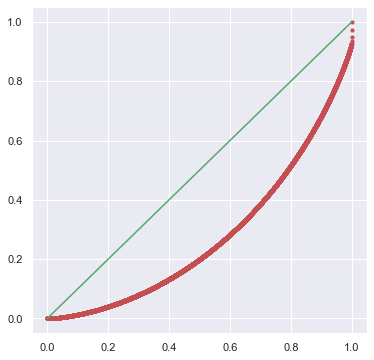

In [47]:
lorenz = ca_cust_sorted['price'].cumsum() / ca_cust_sorted['price'].sum()
fig, ax = plt.subplots(figsize=[6,6])
## scatter plot of Lorenz curve
ax.scatter(np.arange(lorenz.size)/(lorenz.size-1), lorenz, color='r', s=10)
## line plot of equality
ax.plot([0,1], [0,1], color='g')

#### As we can see from the graph our customers have unequal spending. 80% of customers contribute approximately 50% of the amount spent on our website.

In [48]:
# Calculating the gini coefficient
array = ca_cust_sorted["price"].to_numpy()
def gini(array):
    index = np.arange(1,array.shape[0]+1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))
print(gini(array))

0.4463955226980713


#### The coefficient ranges from 0 to 1, with 0 representing perfect equality and 1 representing perfect inequality.
#### The lower the value of the gini coefficient, the more equally customer spending is distributed.

### Question 5: The relationship between the gender of the customer and the category of book bought.

In [53]:
CrosstabResult=pd.crosstab(index=full_data['sex'],columns=full_data['categ'])
print(CrosstabResult)
ChiSqResult = stats.chi2_contingency(CrosstabResult)
print('The P-Value of the ChiSq Test is:', (ChiSqResult[1]))

categ    0.00    1.00   2.00
sex                         
f      206220  114899  17283
m      209460  112270  19200
The P-Value of the ChiSq Test is: 1.1989607410166063e-32


#### Considering the p-value of 0.00 we can conclude that there's no significant relationship between the gender of the customer and the category of books bought

### Question 6a: Correlation between age of customers and total amount spent

In [63]:
#Creating a dataframe with amount spend by age
ca_age = full_data.groupby('age')['price'].sum().reset_index()

#Calculating the correlation and the significance level
corr, p_value = stats.pearsonr(ca_age['age'],ca_age['price'])
print('Pearsons correlation: %.3f' % corr, 'P-value is: %.3f' % p_value)

Pearsons correlation: -0.779 P-value is: 0.000


#### There is a clear, negative correlation between the age of the customer and the amount spent, which means that our older customers spend more

### Question 6b: Correlation between age of customers and frequency of purchase

In [64]:
#Creating a dataframe with the number of sessions per age
session_count = full_data.groupby('age')['session_id'].count().reset_index()

#Calculating the correlation and the significance level
corr, p_value = stats.pearsonr(session_count['age'],session_count['session_id'])
print('Pearsons correlation: %.3f' % corr, 'P-value is: %.3f' % p_value)

Pearsons correlation: -0.534 P-value is: 0.000


#### There is a negative correlation between the age of the customer and the frequency of purchase, which means that older customers tend to purchase more often

### Question 6c: Correlation between age of customers and average shopping basket

In [66]:
#Finding the number of customers for each age
age_count = full_data.groupby(['age'])['client_id'].count().reset_index()

#Creating a dataframe with the number of customers and the amount spent for each age
age_count_price = age_count.merge(ca_age, how = 'left')

#Dividing the amount spent by the number of customers to obtain the average shopping basket per age
age_count_price['avg basket'] = age_count_price['price']/age_count_price['client_id']
age_count_price

,age,client_id,price,avg basket
0,18,15149,609013.69,40.20
1,19,4371,178195.78,40.77
2,20,4587,184209.26,40.16
3,21,4252,178497.70,41.98
4,22,4415,165029.26,37.38
...,...,...,...,...
71,89,327,5264.99,16.10
72,90,311,5043.19,16.22
73,91,170,2815.45,16.56
74,92,226,4013.87,17.76


In [67]:
corr, p_value = stats.pearsonr(age_count_price['age'],age_count_price['avg basket'])
print('Pearsons correlation: %.3f' % corr, 'P-value is: %.3f' % p_value)

Pearsons correlation: -0.548 P-value is: 0.000


#### There is a negative correlation between the age of the customer and the average shopping basket, which means that older customers tend to spend more per purchase

### Question 6d: Correlation between age of client and book categories bought

In [68]:
stats.f_oneway(full_data['age'][full_data['categ'] == 0],
               full_data['age'][full_data['categ'] == 1],
               full_data['age'][full_data['categ'] == 2])

F_onewayResult(statistic=45883.780588713154, pvalue=0.0)

#### There is a statistically significant difference between the category of books our customers buy depending on age. This could be explained by the fact that the categories are related to price and as we have previously seen older people tend to buy more expensive (category 2) books.

#### Further planned or post-hoc comparisons would need to be performed in order to tell which group is different

### Question 7: Probability of a client buying 0_525 if they've bought 2_159

In [94]:
#find clients who've bought 2_159
client_2159 = full_data.loc[full_data.id_prod == "2_159"]
client_2159.drop(columns=['date', 'session_id','price', 'categ'], inplace=True)
clients_2159 = client_2159.groupby(by=["client_id"]).count().reset_index()

#find clients who've bought 0_525
client_0525 = full_data.loc[full_data.id_prod == "0_525"]
client_0525.drop(columns=['date', 'session_id','price', 'categ'], inplace=True)
clients_0525 = client_0525.groupby(by=["client_id"]).count().reset_index()

#find clients who've bought both
clients_both = clients_2159.merge(clients_0525, on='client_id', how='inner')

#calculate probability percentage
print(f"The probability of a customer buying both books is {len(clients_both)/len(clients_2159)*100:.1f}%")

The probability of a customer buying both books is 86.6%
